In [1]:
from __future__ import unicode_literals, division

import IPython
import warnings
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import *
from StringIO import StringIO
from scipy.stats import rankdata
from IPython.display import HTML
from IPython.display import display as prnt

# Notebook Options
%matplotlib inline
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

# Matplotlib Styles
c = {'axes.labelsize': 17,
'axes.titlesize': 16,
'figure.figsize': [18, 8],
'grid.linewidth': 1.6,
'legend.fontsize': 17,
'lines.linewidth': 2,
'lines.markeredgewidth': 0.0,
'lines.markersize': 11,
'patch.linewidth': 0.5,
'xtick.labelsize': 16,
'xtick.major.pad': 20,
'xtick.major.width': 2,
'xtick.minor.width': 1,
'ytick.labelsize': 16.0,
'ytick.major.pad': 20,
'ytick.major.width': 2,
'ytick.minor.width': 1 }
wide_c = dict(c, **{'figure.figsize':[20,8]})

# Source Data
id = '1GnTfMdu9LATsemrfHrnWepsVo-H6oma8AZPXgC7RU1k'
url = 'https://docs.google.com/spreadsheets/d/' + id + '/export?format=csv&id'
r = requests.get(url)
df = pd.read_csv(StringIO(r.content), parse_dates=[u'Timestamp'])

# Episode
episode = lambda x : x - 1
episode_no = episode(2)
episode_list = df['Episode'].unique()
episode_title = episode_list[episode_no]

# Awards
awards = ['Wit','Jockey','Bloodshed','Style','Support']
award_votes = [a[:2]+str(n) for a in awards for n in range(1,4)]
awards_points = [32,16,8]
multiplier = [0.125,0,25,0.5,1,2,4,8]

# Players
id = '1DIVq4s9U_nfY3cHcknGjeV3iGpfW_zxUx-bjFNm4Ebo'
url = 'https://docs.google.com/spreadsheets/d/' + id + '/export?format=csv&id'
r = requests.get(url)
bids = pd.read_csv(StringIO(r.content), parse_dates=[u'Timestamp'])

# Merge in Names
voting_records = df.merge(bids[['Name','Email Address']])

# Data Cleaning
voting_records.columns = ['Timestamp'] + award_votes + ['Email','Episode','Name']
voting_records = voting_records[['Episode','Name'] + award_votes + ['Email','Timestamp']]

# Utility Functions
def table(df,replace_match="",replace_str=""):
    return IPython.display.display(HTML(df.to_html().replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace(replace_match,replace_str)))

# HTML Functions
h1 = lambda x : prnt(HTML('''<h1 style="text-align:center">'''+ x +'''</h1>'''))
h2 = lambda x: prnt(HTML('''<h2 style="text-align:center">'''+ x +'''</h2>'''))
h2_success = lambda x: prnt(HTML('''<h2 style="text-align:center" class="alert alert-success">'''+ x +'''</h2>'''))

h3_danger = lambda x: prnt(HTML('''<h3 style="text-align:center" class="alert alert-danger">'''+ x +'''</h3>'''))
h3_info = lambda x: prnt(HTML('''<h3 style="text-align:center" class="alert alert-info">'''+ x +'''</h3>'''))
h3_warning = lambda x: prnt(HTML('''<h3 style="text-align:center" class="alert alert-warning">'''+ x +'''</h3>'''))

h3 = lambda x : prnt(HTML('''<h3 style="text-align:center">'''+ x +'''</h3>'''))
p  = lambda x : prnt(HTML('''<p class="text_cell_render">'''+ x +'''</p>'''))

md_wrap = lambda s, m, e: reduce(lambda x, y: x + "".join(y), zip(s.split(m), ['<'+e+'>','</'+e+'>'] * int(len(s)/2)), "")[:-3] if (m in s) else s
md_b = lambda s : md_wrap(s,'**','b')
md_i = lambda s :  md_wrap(s,'_','i')

md = lambda s : md_i(md_b(s))

def ul(lis):
    lis = ['''<div class="panel panel-default"><div class="panel-body">''' + md(li) + '''</div></div>''' for li in lis]
    prnt(HTML("".join(lis)))

In [2]:
# DATAFRAMES

rank = lambda x: rankdata(1/x, method='min')
performance_ratio = lambda x: (x / x.sum()) / (prestige.Score_log / prestige.Score_log.sum()).order(ascending=False)

# Roster | Multiplier : [Players]
roster = pd.read_csv('roster.csv').set_index('Multiplier')

# Assassins
assassins = pd.read_csv('assassins.csv').set_index('Character')

# Prestige | Character : [Score, Rank, Multiplier,Score_log]
prestige = pd.read_csv('prestige.csv').set_index('Character')

# Voting Record
voting_record = voting_records[voting_records.Episode == episode_title]

# Votes | IDX : [Episode, Player, Award, Points, Character]
rows = []
for idx, row in voting_record[award_votes].iterrows():
    ep = voting_record.loc[idx].Episode
    player = voting_record.loc[idx].Name
    for jdx, char in enumerate(row):
        award = awards[int(jdx/3)]
        points = awards_points[jdx % 3]
        r = pd.Series([ep, award, points, char, player])
        r.index = ['Episode','Award','Points','Character','Player']
        rows.append(r)
votes = pd.concat(rows, axis=1).T[['Episode','Player','Award','Points','Character']].convert_objects()

# Character Score | Character : [Points, Rank]
scores_character = votes.ix[:, ['Points','Character']].groupby('Character').sum()
scores_character = scores_character.reindex(prestige.index).fillna(0)
scores_character = scores_character.sort('Points', ascending=False)
scores_character['Rank'] = rank(scores_character.Points)

# Performance | Character : [Rating, Rank, Index]
adj_scores_character = votes.ix[:, ['Points','Character']].groupby('Character').sum()
adj_scores_character = adj_scores_character.reindex(prestige.index)
performance = adj_scores_character[['Points']].apply(performance_ratio)
performance = performance * (1/(performance.min())*10)
performance = performance.sort('Points', ascending=False).fillna(0).astype('int')
performance['Rank'] = rank(performance.Points)
performance.ix[performance.Points >= 100,'Index'] = performance.ix[performance.Points >= 100,'Points'] - 100
performance.ix[performance.Points < 100,'Index'] = -1 / (performance.ix[performance.Points < 100,'Points'] / 10000) + 100
performance.Index = performance.Index.replace('-Inf', 0).astype('int')

In [3]:
# table(roster)
# table(assassins)
# table(voting_record)
# table(votes)
# table(scores_character)
# table(performance)

In [4]:
h1('ASCENSION | EPISODE RANKING')

In [5]:
h2(episode_title)

In [6]:
HTML('''<script>

code_show=true;

function code_toggle() {
    if (code_show){ 
        $('div.input').hide();
        $('.output_scroll').removeClass('output_scroll');
        $('.prompt').hide();
    } else {
        $('div.input').show();
        $('.output_scroll').removeClass('output_scroll');
        $('.prompt').show();
    }
    code_show = !code_show
}
</script>
 
<a class='btn btn-warning btn-lg' style="margin:0 auto; display:block; max-width:320px" href="javascript:code_toggle()">TOGGLE CODE</a>''')

In [7]:
rows = []
for idx, row in votes.iterrows():
    row['Cheat'] = True
    mask = roster[row.Player].isin([row.Character])
    if any(mask):
        v = roster.ix[mask, row.Player]
        row['Cheat'] = True
        row['Multiplier'] = v.index[0]
        rows.append(row)

if len(rows) > 0:
    votes = votes.join(pd.DataFrame(rows)[['Cheat','Multiplier']])

    if votes.Cheat.sum > 0:
        h3_text = '''Oath Breakers'''
        p_text = '''Some have broken their oaths, and voted for their own characters! If 
        you recognise your name on this wall of shame, you can rectify what was surely an
        honest mistake by e-mailing Mart your alternative votes for the combination of 
        [Episode, Award, Points, Character] and all scores will be recalculated accordingly.'''

        h3_danger(h3_text)
        p(p_text)
        votes.Cheat[votes.Cheat.isnull()] = False
        cheaters = votes.ix[votes.Cheat, ['Player','Award','Points','Character','Multiplier']]
        cheaters = cheaters.set_index('Player')
        cheaters.index.name = None
        IPython.display.display(HTML(cheaters.to_html().replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-')))
    

h2_success('Episode Voting Results')
h3_info('Stray Observations')
h3_warning('Sherin')

lis = ['''Samwell well deserved the Wit and Support award, pulling out all the stops in his speech nominating Jon Snow and toppling bullies Alliser and Janos. Hereby awarding him an extra 100 invisible Underdog-Burns-Overlord points. How doth it feel at the top, Ivar?''',
'''No surprises that Samwell also wins the Jockey award for making his BFF the leader, but is surprisingly tied with Jon Snow, whose progress was pretty passive this episode. In fact I'd deduct points for his anti-jockey choices to stay at the Night's Watch,upholding certain vows (we didn't catch it the 18th time. Say it again, bro) while having broken others (Ygritte), instead of reuniting with siblings, avenging parents, and realising childhood dream of being Stark.''',
'''Bloodshed award unquestionably goes to Brienne, whose sword had enough velocity to slice through another sword and into a neck.''',
'''Style was won by Daenerys, followed closely by Ellaria Sand, whom I'm awarding an extra 200 invisible points for Best Ornamental Metal. No one voted for Myrcella Baratheon in her barbie princess dress?''',
'''Kent's Kevan Lannister confirms that wit runs in the family, though as Tommen is busy with.. can't think of anything other than pussies (Ser Pounce at this point) and thus unlikely to summon any Masters of War, I think we won't be seeing Kevan for a while. Ser Bronne was also pretty witty with his "mean people always get what's coming to them, one way or another." What way might that be, Ser Bronn? Dan, Kirsty, and Josh know.''',
'''And elsewhere I think there was plenty of wit this episode, cq. Daario: 'The unsullied are too conspicuous. The Second Sons follow people from the taverns into nice, quiet alleys.' Where they have nice, quiet conversations.''',
'''And Tyrion: "She ought to offer her cunt. The best part of her for the best part of me."''',
'''And also scarcity of wit, see Meryn Trant: *Wrong drawf head* 'ARE YOU TRYING TO DECEIVE YOUR QUEEN?!? Shall I throw them in the cell?' Ah, so much brawn, so little brain.''',
'''Contrast with Mart's brainy Qyburn who is seeking ~even more brain~: "I would take the head if you don't mind. It could prove useful for my work."''']
ul(lis)

h3_info('Votes Cast')

Table of votes per Award - columns are the points (32,16,8) each of the votes are worth.

In [8]:
for award in awards:
    prefix = award[:2]
    mask = list(pd.Series(voting_record.columns).str.startswith(prefix))
    votes_award_record = voting_record.ix[:,mask].copy()
    votes_award_record.columns = awards_points
    votes_award_record.index = voting_record.Name
    votes_award_record.index.name = None
    h3_warning(award)
    prnt(HTML(votes_award_record.to_html().replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-')))

,32,16,8
Dan,Tyrion Lannister,Samwell Tarly,Ser Bronn
Hayley,Samwell Tarly,Barristan Selmy,Varys
Jannerah Silverscale,Kevan Lannister,Jaqen Hghar,-
Ivarius Ironsight,Kevan Lannister,Varys,-
Rob o Bones,Samwell Tarly,Jaime Lannister,Tyrion Lannister
Daisy,Jaqen Hghar,Samwell Tarly,Varys
Max Ng,Sansa Stark,Tyrion Lannister,-
Mart,Jaqen Hghar,Varys,Jaime Lannister
Sherin the Sedulous,Daario Naharis,Jaime Lannister,Kevan Lannister
Josh Du,Varys,Ser Bronn,-


,32,16,8
Dan,Jon Snow,Petyr Baelish,Ellaria Sand
Hayley,Arya Stark,Samwell Tarly,Daario Naharis
Jannerah Silverscale,Samwell Tarly,Jaime Lannister,-
Ivarius Ironsight,Jon Snow,Jaime Lannister,-
Rob o Bones,Samwell Tarly,Cersei Lannister,-
Daisy,Samwell Tarly,Jaime Lannister,-
Max Ng,Brienne of Tarth,Daario Naharis,-
Mart,Jaime Lannister,Cersei Lannister,Ser Bronn
Sherin the Sedulous,Arya Stark,Samwell Tarly,Stannis Baratheon
Josh Du,Jon Snow,Cersei Lannister,-


,32,16,8
Dan,Brienne of Tarth,Daenerys Targaryen,Daario Naharis
Hayley,Daenerys Targaryen,Daario Naharis,Grey Worm
Jannerah Silverscale,Daario Naharis,Brienne of Tarth,-
Ivarius Ironsight,Brienne of Tarth,Daario Naharis,-
Rob o Bones,Brienne of Tarth,Daenerys Targaryen,-
Daisy,Daario Naharis,Arya Stark,-
Max Ng,Brienne of Tarth,Daario Naharis,Arya Stark
Mart,Brienne of Tarth,Cersei Lannister,Jaqen Hghar
Sherin the Sedulous,Brienne of Tarth,Daario Naharis,Keyr
Josh Du,Brienne of Tarth,Daario Naharis,-


,32,16,8
Dan,Jaqen Hghar,Ser Bronn,Daenerys Targaryen
Hayley,Missandei,Cersei Lannister,Daenerys Targaryen
Jannerah Silverscale,Daenerys Targaryen,Jaqen Hghar,-
Ivarius Ironsight,Jaqen Hghar,Ellaria Sand,-
Rob o Bones,Daenerys Targaryen,Sansa Stark,Ellaria Sand
Daisy,Ellaria Sand,Jaqen Hghar,-
Max Ng,Doran Martell,Sansa Stark,-
Mart,Doran Martell,Areo Hotah,Jaime Lannister
Sherin the Sedulous,Petyr Baelish,Areo Hotah,Hizdahr zo Loraq
Josh Du,Daenerys Targaryen,Ellaria Sand,-


,32,16,8
Dan,Samwell Tarly,Jaqen Hghar,Podrick Payne
Hayley,Samwell Tarly,Kevan Lannister,Petyr Baelish
Jannerah Silverscale,Brienne of Tarth,Samwell Tarly,Varys
Ivarius Ironsight,Varys,Podrick Payne,Daario Naharis
Rob o Bones,Samwell Tarly,Barristan Selmy,Daario Naharis
Daisy,Podrick Payne,Brienne of Tarth,Hizdahr zo Loraq
Max Ng,Samwell Tarly,Jaime Lannister,Daario Naharis
Mart,Jaqen Hghar,Brienne of Tarth,Jaime Lannister
Sherin the Sedulous,Samwell Tarly,Daario Naharis,Qyburn
Josh Du,Samwell Tarly,Podrick Payne,Barristan Selmy


In [9]:
h3_info('Awards')

Total points scored by each character in the various Award categories

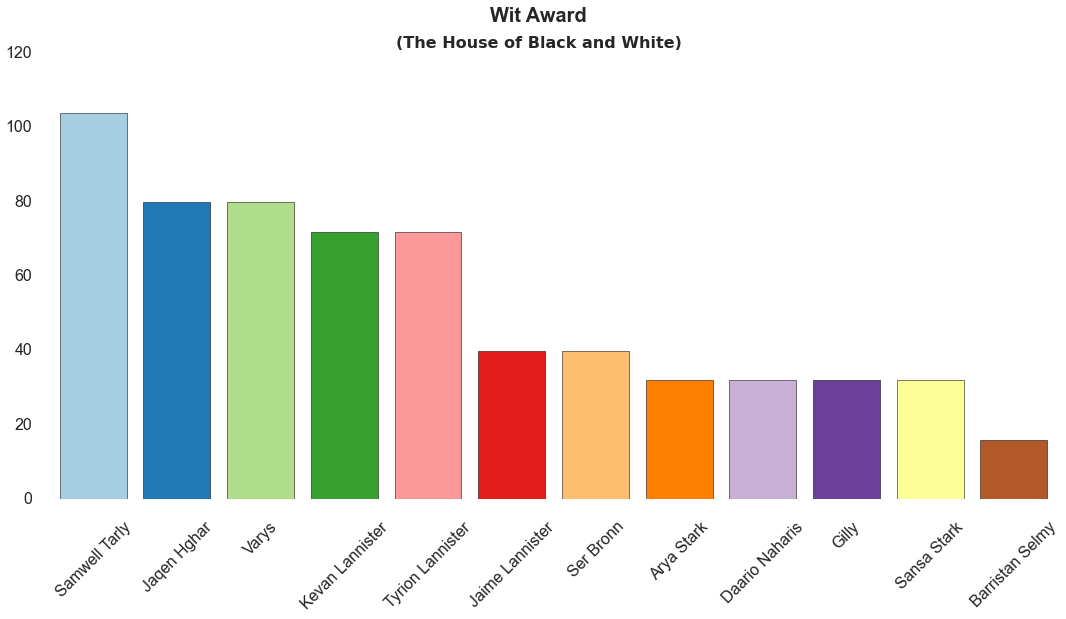

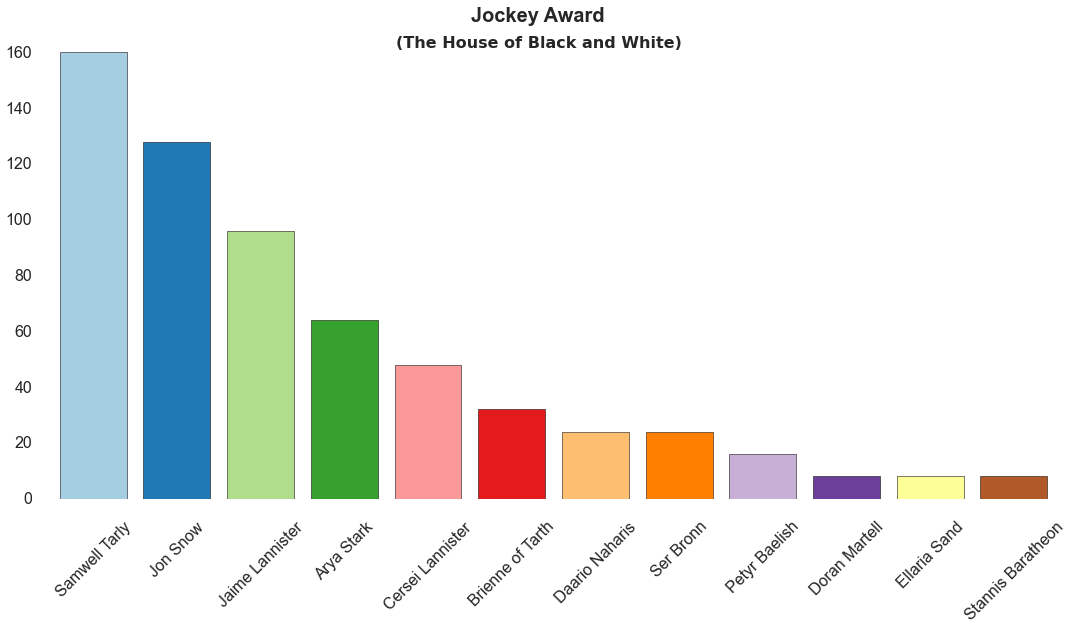

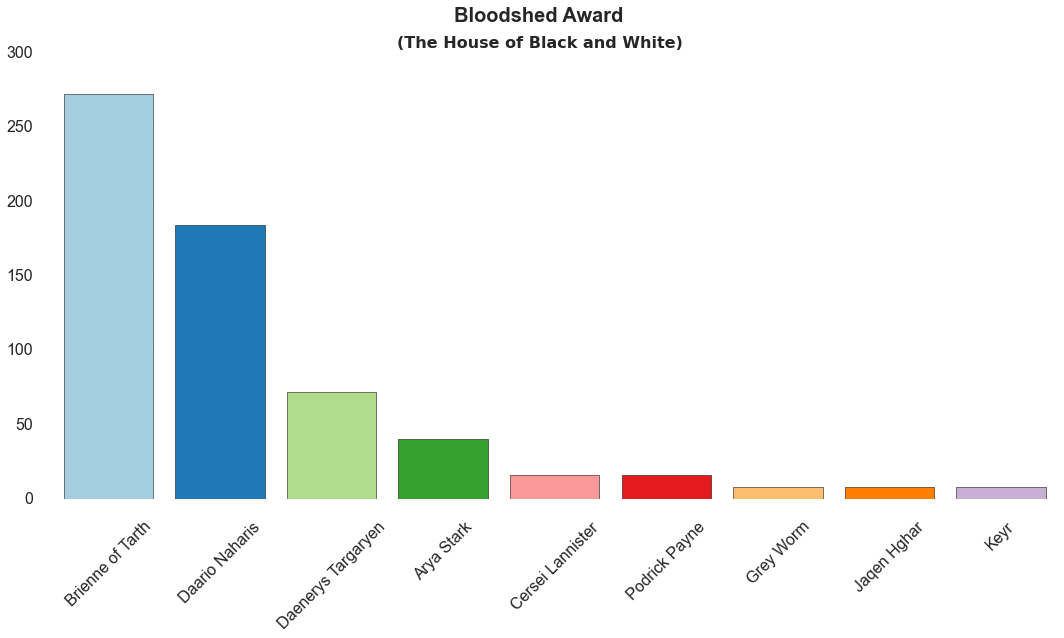

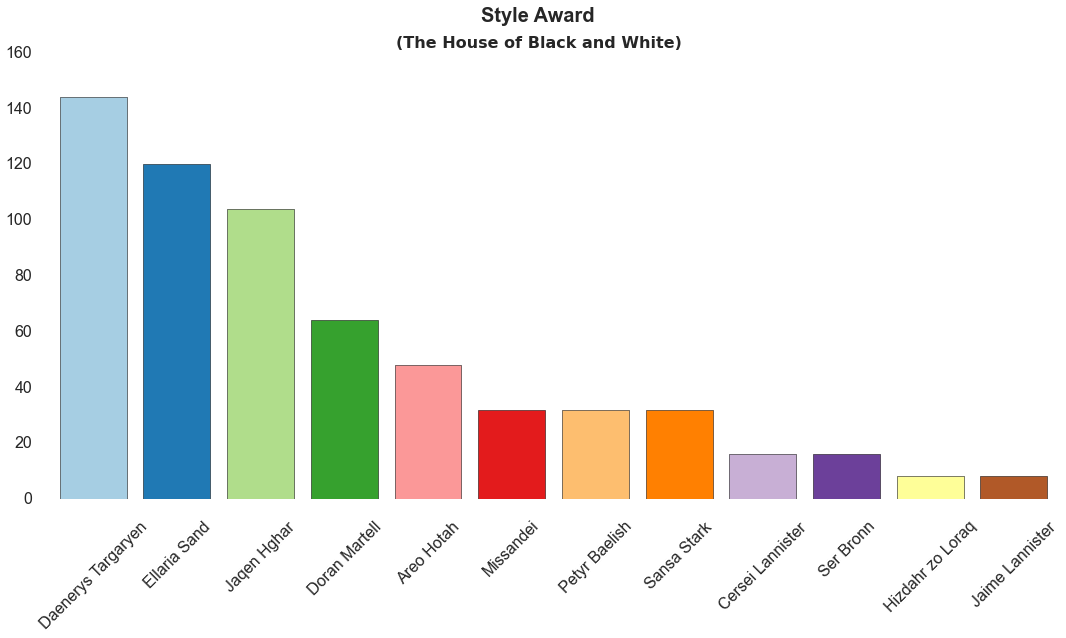

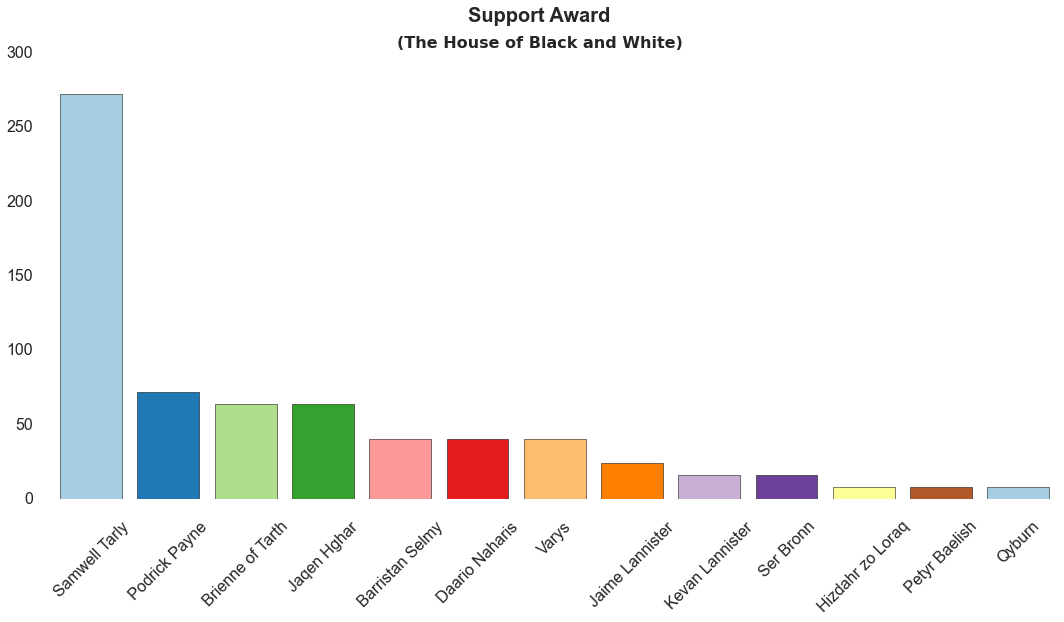

In [10]:
for award in awards:
    valid_votes = votes[votes.Character != False]
    award_ranking = valid_votes.ix[votes['Award'] == award, ['Points','Character']].groupby('Character').sum()
    award_ranking = award_ranking.sort('Points', ascending=False)
    award_ranking['Rank'] = rank(award_ranking.Points)
    with sns.plotting_context("poster", font_scale=1, rc=c):
        d = award_ranking.reset_index()
        f, (ax) = plt.subplots(1, 1)
        g = sns.barplot("Character", "Points", data=d, x_order=d.Character, palette="Paired",ax=ax)
        ax.set_xticklabels(d.Character, rotation=45)
        ax.set_title('(' + ep.split(':')[1].strip() + ')', x=0.485, y=1.00, fontdict={'weight':'bold','family':'Proxima Nova Regular'})
        f.suptitle(award + ' Award', fontsize=20, fontweight='bold')
        f.add_subplot(ax)
        ax.yaxis.label.set_visible(False)
        ax.xaxis.label.set_visible(False)

In [11]:
h3_info('Most Valuable Character')

Total points scored by each character across all award categories.

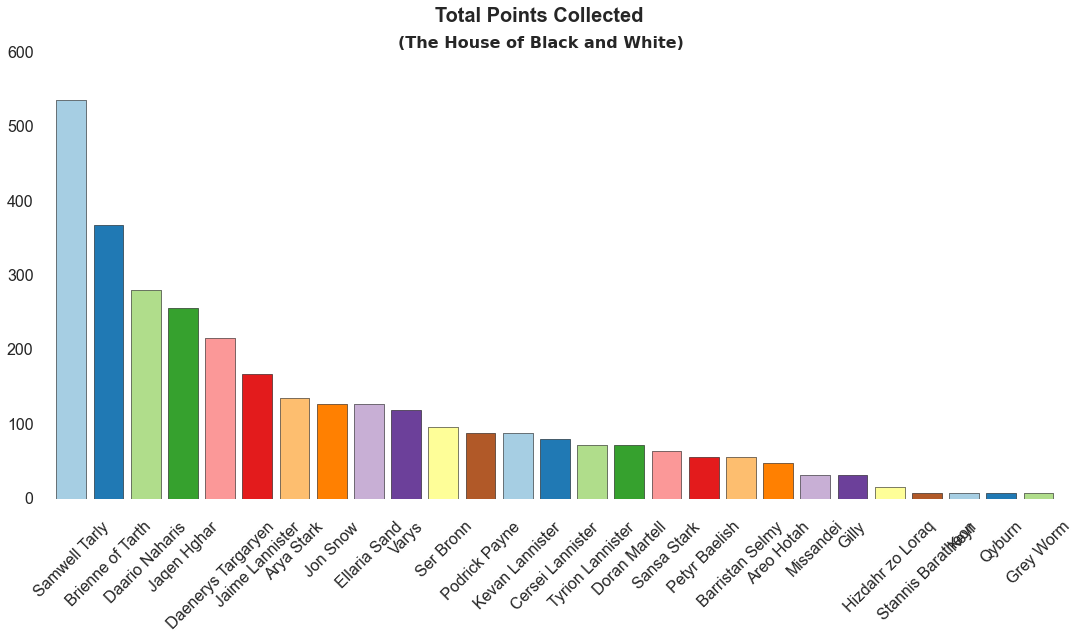

In [12]:
with sns.plotting_context("poster", font_scale=1, rc=c):
    d = scores_character[scores_character.Points > 0].reset_index()
    f, (ax) = plt.subplots(1, 1)
    g = sns.barplot("Character", "Points", data=d, x_order=d.Character, palette="Paired",ax=ax)
    ax.set_xticklabels(d.Character, rotation=45)
    ax.set_title('(' + ep.split(':')[1].strip() + ')', x=0.485, y=1.00, fontdict={'weight':'bold','family':'Proxima Nova Regular'})
    f.suptitle('Total Points Collected', fontsize=20, fontweight='bold')
    f.add_subplot(ax)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

In [13]:
h2_success('Episode Character Performance')

Performance is a ratio measuring the points a character commands vs. the popularity of the character during the bidding round (as expressed in presige points). If a character was neglected during the bidding but scores a lot of points, they are considered to be undervalued. If a character was highly wanted during the bidding process but then failed to attract points, these characters are considered overrated. The relationship between performance, points and prestige is,

$$ performance_i = \frac{points_i}{\sum_{i=0}^{n} points} * \frac{ \log{(prestige_i)} + 1}{ \sum_{i=0}^{n} log{(prestige)} } $$

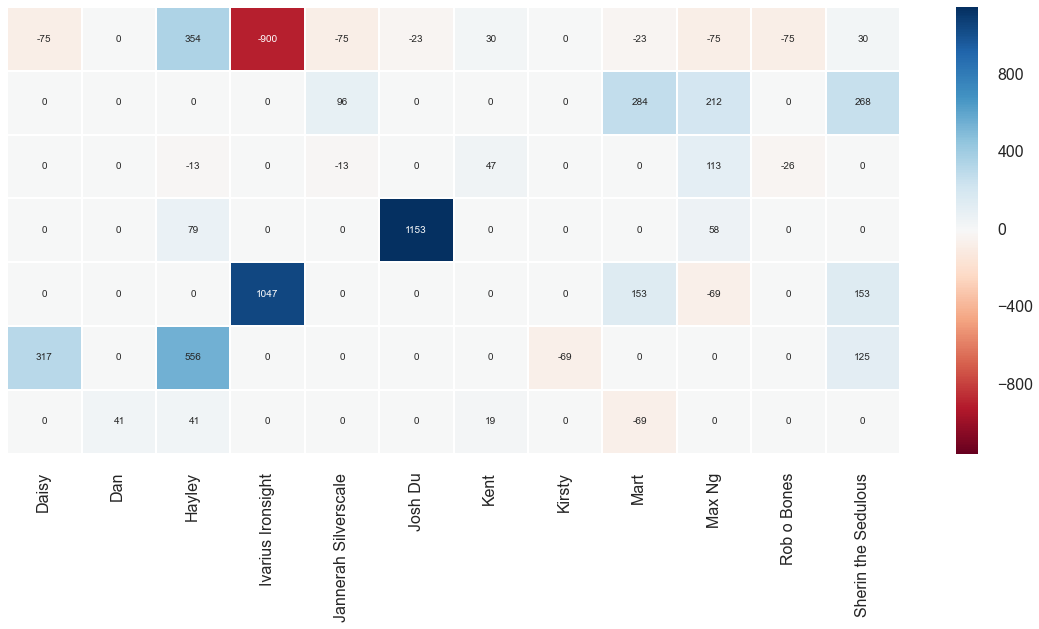

In [14]:
h3 = '''<h3 class='alert alert-info'>Roster Performance</h3>'''
p = '''<p>A Matrix showing all character's performance scores across all player rosters.
The performance scores is indexed on `0` meaning that if they meet expectations -
that is, the proportion of points is equal to the logged proportion of the bid totals.
If they are positive, they are better than expected, negative is worse than expected. For example,
a character who wins 64 points but was only expected to win  32 points based on the votes they received 
in the bidding round will be have a prestige index of '200'. The pressure is on for popular characters to
rake in the points in each episode, whereas the less popular ones have an easier time beating expectations.</p>
<p><b>Characters who weren't voted on this episode are ignored</b></p>'''
IPython.display.display(HTML(h3 + p ))
performance_roster = []
for idx, col in roster.iteritems():
    for char in col:
        performance_roster.append(performance.ix[char,'Index'])

r = np.array(performance_roster).round(0).astype(int).reshape([12,7]).T
performance_roster = pd.DataFrame(r, columns=roster.columns)

with sns.plotting_context("poster", rc=wide_c):
    sns.heatmap(performance_roster.astype(int64), annot=True, fmt='d', yticklabels=False, cmap='RdBu', center=0, annot_kws=None);

In [15]:
h3 = '''<h3 class='alert alert-info'>Most Undervalued Character</h3>'''
p = '''<p>Top 5 Character Performance across all player rosters</p>'''
IPython.display.display(HTML(h3 + p))
d = pd.DataFrame(performance.iloc[:5], columns=['Index']).reset_index()
IPython.display.display(HTML(d.to_html(index=False).replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-')))

Character,Index
Jaime Lannister,1153
Samwell Tarly,1047
Podrick Payne,556
Brienne of Tarth,354
Barristan Selmy,317


In [16]:
h3 = '''<h3 class='alert alert-info'>Most Overrated Character</h3>'''
p = '''<p>Bottom 5 Character Performance across all player rosters</p>'''
IPython.display.display(HTML(h3 + p))
d = pd.DataFrame(performance[performance.Index != 0].Index[-5:], columns=['Index']).reset_index().sort('Index', ascending=True)
IPython.display.display(HTML(d.to_html(index=False).replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-')))

Character,Index
Grey Worm,-900
Petyr Baelish,-75
Keyr,-69
Qyburn,-69
Stannis Baratheon,-69


In [17]:
h3 = '''<h3 class='alert alert-info'>Roster Most Outperforming Expectations</h3>'''
p = '''<p>Given the player's net scores across all their characters' performances, which were the most unexpected successes for this episode.</p>'''
IPython.display.display(HTML(h3 + p))
d = pd.DataFrame(performance_roster.sum()).reset_index()
d.columns=['Player','Index']
d = d.sort('Index', ascending=False)
IPython.display.display(HTML(d[:3].to_html(index=False).replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-')))

Player,Index
Josh Du,1130
Hayley,1017
Sherin the Sedulous,576


In [18]:
h3 = '''<h3 class='alert alert-info'>Roster Which Leave us in Tears</h3>'''
p = '''<p>Given the player's net scores across all their characters' performances, which were the most unexpected no-shows for this episode.</p>'''
IPython.display.display(HTML(h3 + p))
d = pd.DataFrame(performance_roster.sum()).reset_index()
d.columns=['Player','Index']
d = d.sort('Index')
IPython.display.display(HTML(d[:3].to_html(index=False).replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-')))

Player,Index
Rob o Bones,-101
Kirsty,-69
Jannerah Silverscale,8


In [19]:
HTML('''<h2 class='alert alert-success'>Episode Player Score</h2>''')

In [20]:
IPython.display.display(HTML('''<h3 class='alert alert-info'>Player Rosters</h3>'''))
r = roster.copy()
r.index.name = None
IPython.display.display(HTML(r.to_html(index=False).replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-')))
h3 = '''<h3 class='alert alert-info'>Points Scored</h3>'''
p = '''<p>A matrix showing in which rank each player scored their points - you can use thise graph to judge the effect multipliers are having on the game.<p>'''
IPython.display.display(HTML(h3 + p ))

Daisy,Dan,Hayley,Ivarius Ironsight,Jannerah Silverscale,Josh Du,Kent,Kirsty,Mart,Max Ng,Rob o Bones,Sherin the Sedulous
Petyr Baelish,Margaery Tyrell,Brienne of Tarth,Grey Worm,Petyr Baelish,Tyrion Lannister,Varys,Davos Seaworth,Tyrion Lannister,Petyr Baelish,Petyr Baelish,Varys
Maggy the Frog,Pit Announcer,Mance Rayder,Lord of Bones,Arya Stark,Theon Greyjoy,Nymeria Sand,Myrcella Baratheon,Daario Naharis,Daenerys Targaryen,Ramsay Bolton,Jaqen Hghar
Pycelle,Melisandre,Sansa Stark,Gregor Clegane,Sansa Stark,Walda Bolton,Kevan Lannister,Lancel Lannister,The High Sparrow,Jon Snow,Areo Hotah,Olenna Tyrell
Ternesio Terys,Eddison Tollett,Ser Bronn,Yohn Royce,Septa Unella,Jaime Lannister,Mace Tyrell,Malko,Lhara,Cersei Lannister,Bowen Marsh,Tycho Nestoris
Meryn Trant,Jorah Mormont,Robin Arryn,Samwell Tarly,Jorah Mormont,Tyene Sand,Denys Mallister,Shireen Baratheon,Ellaria Sand,Stannis Baratheon,White Walkers Master,Ellaria Sand
Barristan Selmy,Trystane Martell,Podrick Payne,Myranda,Loboda,Alliser Thorne,Tormund Giantsbane,Keyr,Loras Tyrell,Janos Slynt,Trystane Martell,Doran Martell
Olly,Missandei,Gilly,Maggy the Frog,Tommen Baratheon,Yezzan,Hizdahr zo Loraq,Pit Announcer,Qyburn,Roose Bolton,Selyse Baratheon,Obara Sand


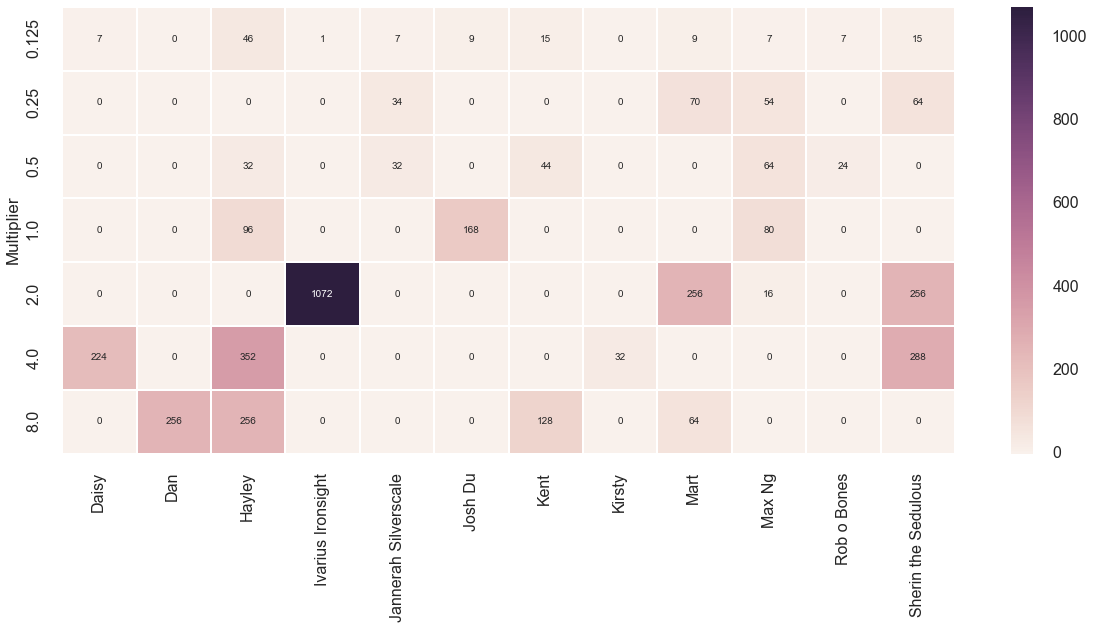

In [21]:
points_scored = roster.copy()
points_scored.ix[:,:] = 0

cheat = False
if 'Cheat' in votes.columns:
    cheat = votes[votes.Cheat]


for char, points in scores_character[['Points']].iterrows():
    for mult, row in roster.iterrows():
        for idx, roster_char in enumerate(row):
            if char == roster_char:
                player = str(row.index[idx])
                if type(cheat) != bool:
                    if len(cheat[cheat.Player.isin([player]) & cheat.Character.isin([char])]) > 0:
                        points = 0
                score = mult * int(points)
                s = "%s scored %s for %s" % (player.upper(), score, char.upper())
                points_scored.ix[mult,player] = score

with sns.plotting_context("poster", rc=wide_c):
    sns.heatmap(points_scored.astype(int64), annot=True, fmt="d");


In [22]:
h3 = '''<h3 class='alert alert-info'>Total Points Earned</h3>'''
p = '''<p>Total points earned by players for this episode, adjusted for character rank.<p>'''
IPython.display.display(HTML(h3 + p ))

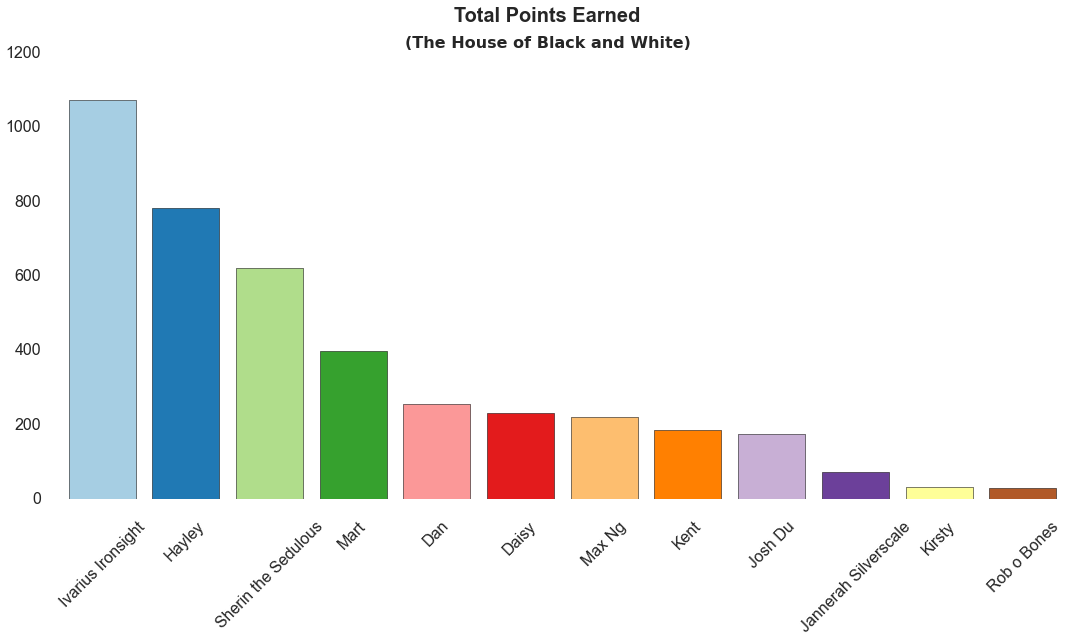

In [23]:
total_points_earned = pd.DataFrame(points_scored.sum(),columns=['Points']).sort('Points', ascending=False)
total_points_earned.index.name = 'Player'
total_points_earned['Rank'] = rank(total_points_earned.Points)
total_points_earned
with sns.plotting_context("poster", font_scale=1, rc=c):
    d = total_points_earned.reset_index()
    f, (ax) = plt.subplots(1, 1)
    g = sns.barplot("Player", "Points", data=d, x_order=d.Player, palette="Paired", ax=ax)
    ax.set_xticklabels(d.Player, rotation=45)
    ax.set_title('(' + ep.split(':')[1].strip() + ')', x=0.485, y=1.00, fontdict={'weight':'bold','family':'Proxima Nova Regular'})
    f.suptitle('Total Points Earned', fontsize=20, fontweight='bold')
    f.add_subplot(ax)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

In [24]:
h3 = '''<h3 class='alert alert-info'>Best Placed Characters</h3>'''
p = '''<p>Of all the character which were bid on, which one earned the most points?<p>'''
IPython.display.display(HTML(h3 + p ))
p_stack = points_scored.stack()
p_stack.index.names = ['Multiplier','Name']
p_stack = p_stack.reset_index('Name')
p_stack.columns = ['Name', 'Points']
p_stack = p_stack.sort('Points', ascending=False)
best_placed_characters = []
most_welcome_assassins = []

for idx, row in p_stack.iterrows():
    if not any(assassins.index.isin(roster.ix[roster.index==idx, row.Name])):
        line = [roster.ix[roster.index==idx, row.Name].iloc[0], idx, row.Name, row.Points]
        best_placed_characters.append(line)
    if len(best_placed_characters) == 3:
        break
for idx, row in p_stack.iterrows():
    if any(assassins.index.isin(roster.ix[roster.index==idx, row.Name])):
        line = [roster.ix[roster.index==idx, row.Name].iloc[0], idx, row.Name, row.Points]
        most_welcome_assassins.append(line)
    if len(most_welcome_assassins) == 3:
        break

d = pd.DataFrame(best_placed_characters,columns=['Character','Multiplier','Player','Points'])
IPython.display.display(HTML(d.to_html(index=False).replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-')))

Character,Multiplier,Player,Points
Samwell Tarly,2,Ivarius Ironsight,1072
Doran Martell,4,Sherin the Sedulous,288
Ellaria Sand,2,Mart,256


In [25]:
# Top 3 Ranking, points earned per character, adjusted for player's rank
h3 = '''<h3 class='alert alert-info'>Most Welcome Assassin</h3>'''
p = '''<p>The assassins often replace more preferred characters, but some assassins are most welcome additions to your team.<p>'''
IPython.display.display(HTML(h3 + p ))
d = pd.DataFrame(most_welcome_assassins,columns=['Character','Multiplier','Player','Points'])
IPython.display.display(HTML(d.to_html(index=False).replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace('NaN','-')))

Character,Multiplier,Player,Points
Podrick Payne,4,Hayley,352
Barristan Selmy,4,Daisy,224
Jaime Lannister,1,Josh Du,168


In [26]:
HTML('''<br><a class='btn btn-primary btn-lg' style="margin:0 auto; display:block; max-width:320px;" href="http://nbviewer.ipython.org/gist/tijptjik/111912a5c86a459fe69e">LEADERBOARD</a> ''')

In [27]:
HTML('''<a class='btn btn-warning btn-lg' style="margin:0 auto; display:block; max-width:320px" href="javascript:code_toggle()">TOGGLE CODE</a>''')

In [28]:
# EXPORT DATAFRAMES

# Votes | IDX : [Episode, Player, Award, Points, Character]
# table(votes)
votes['Episode'] = episode_no
votes.to_csv('votes_' + str(episode_no) + '.csv', encoding='utf-8', index=False)
             
# Character Score | Character : [Points, Rank]
# table(scores_character)
scores_character['Episode'] = episode_no
scores_character.to_csv('scores_character_' + str(episode_no) + '.csv', encoding='utf-8')

# Player Score | Multiplier : [**Players]
# table(points_scored)
points_scored['Episode'] = episode_no
points_scored.to_csv('scores_player_' + str(episode_no) + '.csv', encoding='utf-8')

# Performance | Character : [Rating, Rank, Index]
# table(performance)
performance['Episode'] = episode_no
performance.to_csv('performance_' + str(episode_no) + '.csv', encoding='utf-8')

In [29]:
HTML('''<link href='http://fonts.googleapis.com/css?family=Roboto|Open+Sans' rel='stylesheet' type='text/css'>
<style>
body #notebook {
    font-family : 'Open Sans','Source Sans Pro','Proxima Nova', sans-serif;
    line-height: 1.4em;
    font-size: 1.2em;
    padding: 0 32px;
    line-height: 1.8em;
}

#notebook h1,
#notebook h2,
#notebook h3,
#notebook h4,
#notebook h5 {
    font-family : 'Roboto','Source Sans Pro','Proxima Nova', sans-serif;
}


#notebook .panel-body {
  font-size: 1.1em;
  line-height: 1.6em;
}

#notebook .table,
#notebook .table th,
#notebook .table td,
#notebook .table tr {
    text-align : center;
    border: 0;
    font-size: 1.5rem;
    line-height: 2.2rem
}
</style>

<script>
$(function(){
    code_toggle()
})
</script>

''')